In [359]:
import gc
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler

from lmmnn.nn import reg_nn_ohe_or_ignore, reg_nn_lmm, reg_nn_embed, reg_nn_rnn
from lmmnn.simulation import Count

import tensorflow.keras.backend as K

from sklearn.datasets import make_regression
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
import seaborn as sns
import numpy as np
# from lmmnn.cartesian import cartesian as carte

In [3]:
def cartesian(arrays, out=None):
    """
    Source: https://stackoverflow.com/a/1235363
    Generate a Cartesian product of input arrays.

    Parameters
    ----------
    arrays : list of array-like
        1-D arrays to form the Cartesian product of.
    out : ndarray
        Array to place the Cartesian product in.

    Returns
    -------
    out : ndarray
        2-D array of shape (M, len(arrays)) containing Cartesian products
        formed of input arrays.

    Examples
    --------
    >>> cartesian(([1, 2, 3], [4, 5], [6, 7]))
    array([[1, 4, 6],
           [1, 4, 7],
           [1, 5, 6],
           [1, 5, 7],
           [2, 4, 6],
           [2, 4, 7],
           [2, 5, 6],
           [2, 5, 7],
           [3, 4, 6],
           [3, 4, 7],
           [3, 5, 6],
           [3, 5, 7]])

    """

    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    #m = n / arrays[0].size
    m = int(n / arrays[0].size)
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m, 1:])
        for j in range(1, arrays[0].size):
        #for j in xrange(1, arrays[0].size):
            out[j*m:(j+1)*m, 1:] = out[0:m, 1:]
    return out

(200, 3) (200, 1)


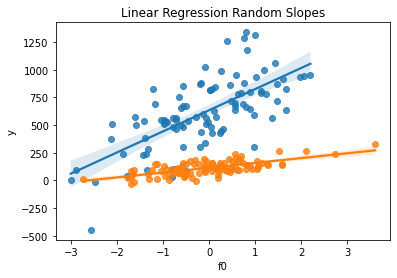

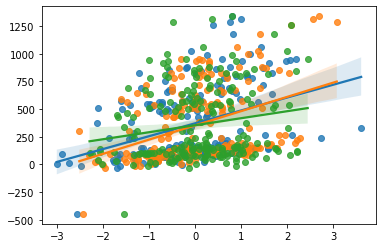

In [520]:
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt
import seaborn as sns
import random

no_meaningful_groups = 1
n_features = 3
n_samples_per_group = 100

meaningful_groups = {f"g{i}": [0,1] for i in range(1,no_meaningful_groups+1)}
n_samples_per_group = 100
combinations = cartesian([v for v in meaningful_groups.values()])
# random.shuffle(combinations)

X, y = make_regression(n_samples=n_samples_per_group * len(combinations), n_features=n_features, noise=0.3)

start = 0
for c in combinations:
    y[start:(start+n_samples_per_group)] += np.random.random()*500
    y[start:(start+n_samples_per_group)] = y[start:(start+n_samples_per_group)]*np.random.random()*3
    sns.regplot(x=X[start:(start+n_samples_per_group),0], y=y[start:(start+n_samples_per_group)])
    start += n_samples_per_group

X_features = X
X_groups = np.repeat(combinations, n_samples_per_group, axis=0)
print(X.shape, X_groups.shape)

X = np.concatenate([X_features, X_groups], axis=1)
plt.xlabel("f0")
plt.ylabel("y")
plt.title("Linear Regression Random Slopes")
plt.figure()

for i in range(n_features):
  sns.regplot(x=X[:,i], y=y)

In [426]:
combinations

array([[0, 0],
       [0, 1],
       [1, 0],
       [1, 1]])

In [524]:
df = pd.DataFrame(X, columns=[f"f{i}" for i in range(n_features)] + list(meaningful_groups.keys()))

# for i in range(4,51):
#     df[f"g{i}"] = np.random.randint(0, 2, size=len(df))

df["y"] = y
df.head()

c = df.filter(regex="g").columns
df[c] = df[c].astype(int)
df

,f0,f1,f2,g1,y
0,-0.727650,0.467400,-0.066739,0,563.677775
1,-0.661174,1.149322,0.524738,0,754.621259
2,0.485411,0.088725,-0.026267,0,720.922629
3,-0.057854,-0.064782,-1.009949,0,507.616950
4,-0.171625,1.452314,0.298443,0,882.505826
...,...,...,...,...,...
195,-0.226962,-0.846221,0.119400,1,70.491920
196,-0.620270,0.024000,1.043511,1,105.776123
197,-0.640103,0.445897,-0.633877,1,91.897389
198,-0.088791,-0.990123,0.690084,1,80.411786


In [525]:
df_original = df.copy()

In [539]:
df = df_original.copy()

In [16]:
from itertools import combinations as get_combi

all_combi = []

grouping_col = [i for i in df.columns if i.startswith('g')]
# for i in range(1, len(grouping_col)+1):
#     combi = list(get_combi(grouping_col, i))
#     # random.shuffle(combi)
#     all_combi.append(combi)

# all_combi = [item for sublist in all_combi for item in sublist]
all_combi = list(get_combi(grouping_col, 3))
len(all_combi)

0

In [257]:
select = ["f0","f1","f2","g1","g2","g3","g5","y"]

df = df[select]
df

,f0,f1,f2,g1,g2,g3,g5,y
0,-0.199730,0.532481,-0.642641,0,0,0,0,38.770109
1,0.762719,0.807589,0.156739,0,0,0,1,160.457764
2,-1.060291,-0.628212,-0.689583,0,0,0,0,-50.684511
3,0.256058,-1.916332,0.026101,0,0,0,0,90.375436
4,0.629465,-1.128237,1.272490,0,0,0,1,177.705570
...,...,...,...,...,...,...,...,...
795,-0.242130,1.551650,0.828692,1,1,1,1,88.318362
796,0.812942,-0.288802,0.819337,1,1,1,1,173.860593
797,0.174307,-0.874811,-0.689628,1,1,1,1,53.226137
798,-0.081690,-0.303491,0.515108,1,1,1,0,79.033080


In [540]:
g_cols = [i for i in df.columns if i.startswith('g')]
df['g_cart'] = df[g_cols].apply(lambda row: '_'.join(row.astype(str)), axis=1)
df["g_cart"] = pd.factorize(df['g_cart'])[0]
df.drop(g_cols, axis=1, inplace=True)

f_cols = [i for i in df.columns if i.startswith('f')]
df['t'] = df[f_cols].mean(axis=1)
df['t'] = pd.qcut(df['t'], q=len(df), labels=False)

df

,f0,f1,f2,y,g_cart,t
0,-0.727650,0.467400,-0.066739,563.677775,0,84
1,-0.661174,1.149322,0.524738,754.621259,0,137
2,0.485411,0.088725,-0.026267,720.922629,0,121
3,-0.057854,-0.064782,-1.009949,507.616950,0,45
4,-0.171625,1.452314,0.298443,882.505826,0,161
...,...,...,...,...,...,...
195,-0.226962,-0.846221,0.119400,70.491920,1,52
196,-0.620270,0.024000,1.043511,105.776123,1,115
197,-0.640103,0.445897,-0.633877,91.897389,1,60
198,-0.088791,-0.990123,0.690084,80.411786,1,80


In [541]:
df.rename(columns={'g_cart': 'z0'}, inplace=True)
df.rename(columns={'g1': 'z1', 'g2':'z2'}, inplace=True)

print(df.head())

         f0        f1        f2           y  z0    t
0 -0.727650  0.467400 -0.066739  563.677775   0   84
1 -0.661174  1.149322  0.524738  754.621259   0  137
2  0.485411  0.088725 -0.026267  720.922629   0  121
3 -0.057854 -0.064782 -1.009949  507.616950   0   45
4 -0.171625  1.452314  0.298443  882.505826   0  161


In [464]:
len(df['z0'].unique())

4

In [542]:
mode = 'slopes'
# mode = 'intercepts'
n_cats = [len(df['z0'].unique())]
qs = n_cats
batch_size = 32
epochs = 500
patience = 10
n_sig2bs = 3
n_sig2bs_spatial = 0
est_cors = []
n_neurons = [50,25,12,6]
activation = 'linear'
dropout = []
spatial_embedded_neurons = []
dist_matrix = None
q_spatial = None

In [545]:
from sklearn.model_selection import train_test_split
# X, y = df.drop('target', axis=1), df['target']
X, y = df.drop('y', axis=1), df['y']

x_cols = [col for col in X.columns if col not in ['z0','z1','z2','z3']]
cols_to_scale = [col for col in X.columns if col not in ['z0','z1','z2','z3','t']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

scaler = StandardScaler()
X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale]) #.values.reshape(-1,1))
X_test[cols_to_scale]  = scaler.transform(X_test[cols_to_scale]) #.values.reshape(-1,1))

X_train.head()

,f0,f1,f2,z0,t
42,1.443611,-1.168539,0.195337,0,0.381812
189,-0.499554,-1.192832,1.896131,1,0.138593
90,-1.777149,-0.703654,0.781137,0,-1.164365
136,1.032501,0.524900,-0.374495,1,0.868250
51,-1.315341,-0.035040,-0.010055,0,-1.042756


### Simple Linear Regression

mse-test: 117984.22725939914
mae-test: 226.28866983527226


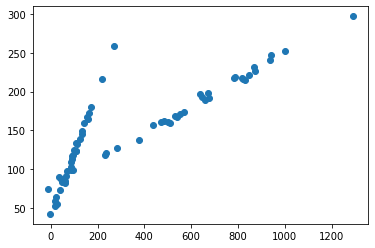

In [530]:
from sklearn.svm import SVR

svr = SVR(kernel='linear')
svr.fit(X_train, y_train)
svr_pred = svr.predict(X_test)

print("mse-test:", mse(y_test,svr_pred))
print("mae-test:", mae(y_test,svr_pred))
plt.scatter(y_test, svr_pred)

mse-test: 43977.84787262964
mae-test: 165.37326024333296


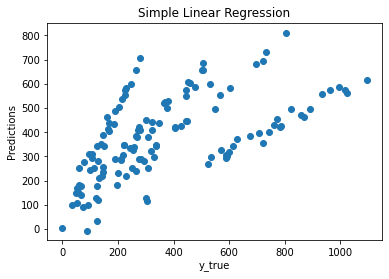

In [502]:
reg = LinearRegression(fit_intercept=True)
reg.fit(X_train, y_train)
pred = reg.predict(X_test)

plt.scatter(y_test, pred)
plt.xlabel("y_true")
plt.ylabel("Predictions")
plt.title("Simple Linear Regression")
print("mse-test:", mse(y_test,pred))
print("mae-test:", mae(y_test,pred))

In [287]:
# Scalling label (Optional)

scaler = StandardScaler()
y_train = scaler.fit_transform(y_train.values.reshape(-1, 1)).reshape(X_train.shape[0])
y_test = scaler.transform(y_test.values.reshape(-1, 1)).reshape(X_test.shape[0])
y_train = pd.Series(y_train, index=X_train.index)
y_test = pd.Series(y_test, index=X_test.index)
scaler = StandardScaler()
X_train[x_cols] = scaler.fit_transform(X_train[x_cols])
X_test[x_cols] = scaler.transform(X_test[x_cols])


### LMMNN

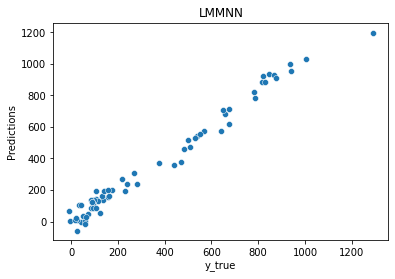

 finished lmm, mse: 2241.2465
 finished lmm, MAE: 38.3286


In [546]:
def reg_nn(X_train, X_test, y_train, y_test, n_cats, batch=batch_size, epochs=epochs, patience=patience, reg_type='lmm', verbose=False):

    start = time.time()
    if reg_type == 'lmm':
        y_pred, sigmas, _, _, n_epochs = reg_nn_lmm(X_train, X_test, y_train, y_test, n_cats, q_spatial, x_cols, batch, epochs, patience,
                                                 n_neurons, dropout, activation,
                                                 mode=mode, n_sig2bs=n_sig2bs, n_sig2bs_spatial=n_sig2bs_spatial,
                                                 est_cors=est_cors, dist_matrix=dist_matrix,
                                                 spatial_embed_neurons=spatial_embedded_neurons, verbose=verbose, log_params=False)
    else:
        raise ValueError(reg_type + 'is an unknown reg_type')
    end = time.time()
    gc.collect()
    K.clear_session()
    mse = np.mean((y_pred - y_test)**2)
    sns.scatterplot(x=y_test, y=y_pred)
    plt.xlabel("y_true")
    plt.ylabel("Predictions")
    plt.title("LMMNN")
    plt.show()

    return mse, sigmas, n_epochs, end - start, y_pred

mse_lmm, sigmas, n_epochs_lmm, time_lmm,y_pred= reg_nn(X_train, X_test, y_train, y_test, n_cats, reg_type='lmm', verbose=False)
print(' finished lmm, mse: %.4f' % (mse_lmm))
print(' finished lmm, MAE: %.4f' % (mae(y_test, y_pred)))

In [289]:
print(f"      y_test \t\t |      y_pred \t\t |        Diff \n")
for i,j  in zip(y_test[:5], y_pred[:5]):
    print(f"{i} \t | {j} \t | {i-j}")

      y_test 		 |      y_pred 		 |        Diff 

-0.25671187690023206 	 | 0.15790681397534276 	 | -0.4146186908755748
-0.6546577134834899 	 | 0.07094382344026794 	 | -0.7256015369237578
-1.8574010718815088 	 | -0.44069909181339406 	 | -1.4167019800681149
-0.22440292286950894 	 | -0.09299718886951869 	 | -0.13140573399999025
1.6602475115287416 	 | 0.3988492378467474 	 | 1.2613982736819942


### Mixedlm

In [100]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error as mse

In [203]:
df = df_original.copy()

In [436]:
g_cols = [i for i in df.columns if i.startswith('g')]
df['g_cart'] = df[g_cols].apply(lambda row: '_'.join(row.astype(str)), axis=1)
df["g_cart"] = pd.factorize(df['g_cart'])[0]
# df.drop(g_cols, axis=1, inplace=True)
df

,f0,f1,f2,g1,g2,y,g_cart
0,0.565450,-0.984085,0.151530,0,0,174.489650,0
1,-0.276258,-0.405588,0.270439,0,0,167.097450,0
2,0.871799,0.608834,-1.135796,0,0,306.302422,0
3,-1.844351,-0.658855,0.220759,0,0,31.747917,0
4,0.622406,-0.286180,0.726583,0,0,250.152408,0
...,...,...,...,...,...,...,...
395,0.436511,0.058118,0.520326,1,1,511.157189,3
396,-1.595818,-0.144887,-0.383849,1,1,330.840736,3
397,0.569806,-0.110795,-0.087320,1,1,494.252268,3
398,-0.340170,-1.206504,-0.339806,1,1,330.041792,3


In [437]:
from sklearn.model_selection import train_test_split
# X, y = df.drop('target', axis=1), df['target']
X, y = df.drop('y', axis=1), df['y']

cols_to_scale = [col for col in X.columns if col not in ['g1','g2','g_cart']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

scaler = StandardScaler()
X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale]) #.values.reshape(-1,1))
X_test[cols_to_scale]  = scaler.transform(X_test[cols_to_scale]) #.values.reshape(-1,1))

X_train.head()

,f0,f1,f2,g1,g2,g_cart
258,-0.481714,0.580558,0.153962,1,0,2
177,0.651697,0.299833,-0.193465,0,1,1
119,0.237356,-0.654044,-0.490791,0,1,1
194,0.382524,-0.392652,-1.501054,0,1,1
229,-0.140616,-0.843092,1.101469,1,0,2


In [438]:
data_train = pd.concat([X_train, y_train], axis=1)
# data_train['f0_int'] = data_train['f0'].astype(int)
data_train

,f0,f1,f2,g1,g2,g_cart,y
258,-0.481714,0.580558,0.153962,1,0,2,305.628319
177,0.651697,0.299833,-0.193465,0,1,1,220.449273
119,0.237356,-0.654044,-0.490791,0,1,1,103.134401
194,0.382524,-0.392652,-1.501054,0,1,1,115.590010
229,-0.140616,-0.843092,1.101469,1,0,2,225.921621
...,...,...,...,...,...,...,...
71,-0.228026,-1.996737,-2.122677,0,0,0,-16.075817
106,0.454499,-0.199307,0.931452,0,1,1,186.493377
270,0.501837,1.291281,-1.062661,1,0,2,412.806576
348,0.001780,0.263547,0.149107,1,1,3,489.677877


In [166]:
df_test = df.drop('y', axis=1)
df_test

,f0,f1,f2,g1,g2,g_cart
0,1.077679,0.747072,1.478063,0,0,0
1,0.794614,1.121797,0.934718,0,0,0
2,-0.811348,0.461745,0.042378,0,0,0
3,1.482100,0.347183,0.519743,0,0,0
4,-1.283598,0.694539,1.074801,0,0,0
...,...,...,...,...,...,...
395,2.126119,-0.564411,0.678874,1,1,3
396,-1.382368,0.871280,-1.790818,1,1,3
397,0.911855,0.247852,-0.635588,1,1,3
398,-0.993673,-0.606541,-0.960280,1,1,3


In [439]:
md = sm.MixedLM.from_formula("y ~ f0 +f1+f2 + (0 | g2*g1)",
    data_train,
#     re_formula = "~ 1 + f0+f1+f2+g1+g2",
#     vc_formula = {'f0': '1 +C(f0)', 'f1': '1 +C(f1)', 'f2': '1 +C(f2)'},
    groups = data_train['g_cart']
)
mdf = md.fit()
print(mdf.summary())
print("MSE-train: ", mse(data_train.y, mdf.fittedvalues))
mlm_pred = mdf.predict(X_test)
print("MSE-test: ", mse(y_test, mlm_pred))

           Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   y       
No. Observations:   268       Method:               REML    
No. Groups:         4         Scale:                0.0808  
Min. group size:    61        Log-Likelihood:       -58.8727
Max. group size:    70        Converged:            Yes     
Mean group size:    67.0                                    
------------------------------------------------------------
           Coef.    Std.Err.     z     P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept 214.159       0.287  747.103 0.000 213.597 214.721
f0         71.241       0.017 4078.086 0.000  71.207  71.276
f1         85.846       0.017 4924.488 0.000  85.812  85.880
f2         19.989       0.018 1140.075 0.000  19.955  20.024
0 | g2    -62.037       0.405 -153.114 0.000 -62.832 -61.243
g1         72.885       0.405  179.880 0.000  72.091  73.680
0 | g2:g1 238.655       0.573  416.5

Train Data


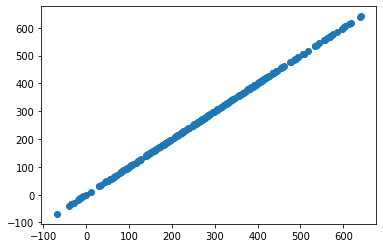


Test Data


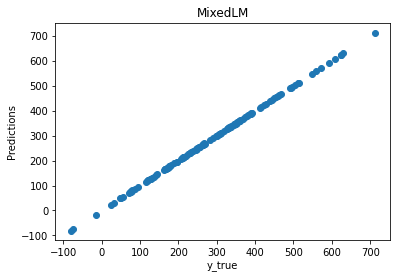

MSE-train:  0.07872621356163757
MSE-test:  0.09634338531617204


In [441]:
print("Train Data")
plt.scatter(data_train.y, mdf.fittedvalues)
plt.show()

print("\nTest Data")
plt.scatter(y_test, mlm_pred)
plt.xlabel("y_true")
plt.ylabel("Predictions")
plt.title("MixedLM")
plt.show()
print("MSE-train: ", mse(data_train.y, mdf.fittedvalues))
print("MSE-test: ", mse(y_test, mlm_pred))

In [547]:
print(f"      y_test \t\t |      mlm_pred \t\t |        Diff \n")
for i,j  in zip(y_test[:5], mlm_pred[:5]):
    print(f"{i} \t | {j} \t | {i-j}")

      y_test 		 |      mlm_pred 		 |        Diff 

787.3734092226396 	 | 438.3175468630378 	 | 349.05586235960175
567.2664830617057 	 | 213.14343486045803 	 | 354.1230482012477
230.8939610133671 	 | 219.76087254737388 	 | 11.133088465993211
173.16618920559168 	 | 382.4072611560722 	 | -209.24107195048052
40.7301989899446 	 | 504.11687437795257 	 | -463.386675388008


In [235]:
import pandas as pd
import statsmodels.api as sm

# Example data
data = pd.DataFrame({
    'y': [10, 15, 20, 25, 30],
    'x1': [-1.2, 2.5, 3.1, 4.9, 5.25],
    'x2': [1.22, 2.5, 3.1, 4.9, 4.25],
    'group': [1, 1, 2, 2, 3]
})
data['x_int_1'] = data['x1'].astype(int)
data['x_int_2'] = data['x2'].astype(int)


# Fit mixed-effects model with random intercepts and slopes
formula = "y ~ x1 + x2 + (x_int_2 | group)"
model = sm.MixedLM.from_formula(formula, data=data, groups=data['group'])
result = model.fit()
print(result.summary())


        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: y      
No. Observations: 5       Method:             REML   
No. Groups:       3       Scale:              8.6794 
Min. group size:  1       Log-Likelihood:     -5.4810
Max. group size:  2       Converged:          Yes    
Mean group size:  1.7                                
-----------------------------------------------------
                Coef.  Std.Err. z P>|z| [0.025 0.975]
-----------------------------------------------------
Intercept       11.194                               
x1               0.915                               
x2              -1.286                               
x_int_2 | group  2.595                               
Group Var        8.679                               



C:\Users\htals\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2705: RuntimeWarning: invalid value encountered in sqrt
  sdf[0:self.k_fe, 1] = np.sqrt(np.diag(self.cov_params()[0:self.k_fe]))


In [229]:
data

,y,x,group
0,10,-1.20,1
1,15,2.50,1
2,20,3.10,2
3,25,4.90,2
4,30,5.25,3
